# Classificatore BiLSTM del data set BBC usando fasttext

Il dataset BBC si trova all'indirizzo: https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv. Scarichiamo il dataset e lo carichiamo su Google Colab.

Il file va uploadato su Drive e il Drive va montato nel runtime. 

```python
from google.colab import drive

drive.mount('/content/gdrive')
```

Se non si dispone di spazio sufficiente sul proprio Drive allora è opportuno che, una volta creato il notebook e connesso il relativo runtime, si apra l'icona del filesytem e, all'interno della cartella ```/content``` si faccia il drag & drop del file stesso in modo da usare l'ampio spazio fornito direttamente dal runtime. 

Ovviamente alla fine della sessione si perderà tutto il contenuto e si dovrà ripetere il processo in caso che il file debba essere usato nuovamente.

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from torch import nn
from torch.optim import Adam
import torch

In [4]:
root = "/home/rpirrone/src/"                         # Inserire il proprio percorso
df = pd.read_csv(root+"bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


n samples -> 2225
categories -> {'tech', 'sport', 'politics', 'business', 'entertainment'}[5]
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


<Axes: xlabel='category'>

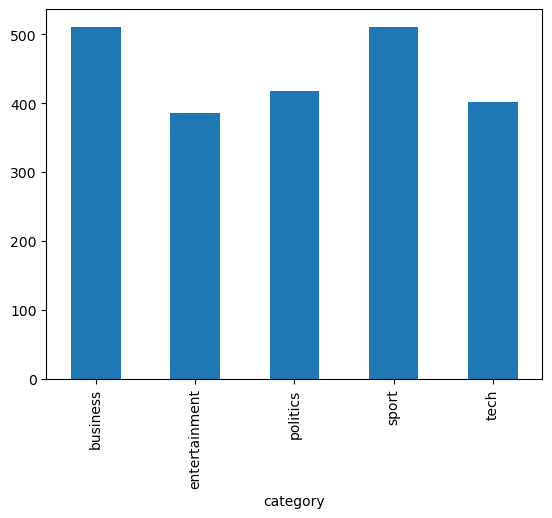

In [5]:
# il dataset è formato da 2225 sample contenenti articoli della BBC
# suddivisi in 5 categorie in base al loro topic

print('n samples -> '+str(len(df)))
labels = set(df['category'])
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(df['category'].value_counts())
df.groupby(['category']).size().plot.bar()

In [6]:
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

In [7]:
df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

In [8]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(
    df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split(
    x_train, y_train, test_size=0.1, random_state=17)

# sarebbe uno split 80-20 con un 10% del training set (8% dei campioni) come validation set

In [9]:
# Creiamo il nostro Dataset torch personalizzato
nltk.download('punkt_tab')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        if stopwords:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]

            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("english")]))

        else:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
            # for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... ',total=len(tokens_litt)):
                sentence_clean = ' '.join([w for w in sentence])
                text_clean.append(sentence_clean)
            # ogni token è separato dall'altro con uno spazio
        self.texts = [text for text in text_clean]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    # overvwrite della classe Dataset
    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    # overvwrite della classe Dataset
    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/rpirrone/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rpirrone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    "stopwords": False,
    "layers": 1,
    "h_dim": 300,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01
}

In [11]:
#creare dataset e mapping delle labels

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 67876.40it/s]


In [ ]:
# Creiamo la nostra rete neurale
class EmbsLSTMClassifierDeep(nn.Module):

    def __init__(self, labels, lstm_layers, lstm_hdim, bilstm, dropout):
        super(EmbsLSTMClassifierDeep, self).__init__()
        self.lstm = nn.LSTM(lstm_hdim, lstm_hdim, lstm_layers,
                            bidirectional=bilstm, batch_first=True)
        if bilstm:                      # Predisponiamo la dimensione dell'output in caso di BiLSTM
            lstm_output = lstm_hdim*2
        else :
            lstm_output = lstm_hdim
        self.bilstm = bilstm
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output, lstm_output),
            nn.BatchNorm1d(lstm_output),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(lstm_output, labels))

    # Calcolo in avanti del grafo di computazione della rete
    def forward(self, input_texts):
        _output, (hn, _cn) = self.lstm(input_texts)     # parte profonda della rete (Bi)LSTM
        if not self.bilstm:
            lstm_output = hn[-1,:,:]
        else:
            lstm_output = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1) # cat degli hidden state forward e backward
        
        logits = self.classifier(lstm_output)           # testa di classificazione che estrae i logits
        pred_probab = nn.LogSoftmax(dim=1)(logits)      # uscita esplicita con log-softmax per la predizione delle etichette
        return pred_probab

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza


In [14]:
# creiamo gli embedding con fasttext
def gen_embeddings_fast_text(tokens, ft):
    embeddings = []
    for sentence in tokens:
        emb = []
        for word in sentence:
            emb.append(torch.tensor((ft[word])))
        embeddings.append(torch.stack(emb))
    return embeddings

# massima lunghezza dei tweet
def get_max_len(tweets_embeddings):
    max_len = 0
    for e in tweets_embeddings:
        if e.shape[0] > max_len: max_len = e.shape[0]
    return max_len

In [ ]:
def train_loop(model, dataloader, ft, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()   # ad ogni passo azzeriamo i gradienti per reinizializzare
                                # il loro calcolo allo step successivo

        tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]

        embeddings = gen_embeddings_fast_text(tokens, ft)
        max_len_batch = get_max_len(embeddings)
        
        # pad del tensore con 0 tanti quanti ne sono necessari ad ogni riga fasttext che ha lunghezza
        # variabile sulla prima dimensione, pari al numero delle parole mentre la seconda è fissa a 300.
        # Il pad, quindi, è pari a: (0,0) sulla seconda dimensione
        #                           (0,lunghezza massima - lunghezza della riga corrente) sulla prima
        input_embeddings =  torch.stack([torch.nn.functional.pad(x,
                                                                 (0,0,0, max_len_batch - x.shape[0])) for x in embeddings])\
                                                                .to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_embeddings)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando l'argmax sulle uscite softmax del classificatore
        epoch_acc += (output.argmax(dim=1) == batch_labels).sum().item()

        # spostiamo in cpu tutto ciò che riguarda questa epoca
        batch_labels = batch_labels.detach().cpu()
        input_embeddings = input_embeddings.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def test_loop(model, dataloader, ft, loss, device):
    
    # Impostiamo la modalità di valutazione del modello: è una best practice che serve per il
    # dropout e/o batch normalization
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():       # senza calcolare i gradienti

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]

            embeddings = gen_embeddings_fast_text(tokens, ft)
            max_len_batch = get_max_len(embeddings)
            input_embeddings =  torch.stack([torch.nn.functional.pad(x, (0,0,0,
                max_len_batch-x.shape[0])) for x in embeddings]).to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_embeddings)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # per calcolare l'accuracy devo generare le predizioni applicando l'argmax sulle uscite softmax del classificatore
            epoch_acc += (output.argmax(dim=1) == batch_labels).sum().item()

            # di nuovo spostiamo in cpu
            batch_labels = batch_labels.detach().cpu()
            input_embeddings = input_embeddings.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

I vettori fasttext si possono scaricare installando i seguenti pacchetti (descrizione in https://fasttext.cc/docs/en/python-module.html):

```bash
$ !pip install fasttext
$ !pip install huggingface-hub
```

In alternativa si possono scaricare preaddestrati da https://fasttext.cc/docs/en/english-vectors.html .

In [ ]:
import fasttext
import nltk
from huggingface_hub import hf_hub_download

def train_test(model,
               epochs,
               optimizer,
               device,
               train_data,
               test_data,
               batch_size,
               train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addestrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    # Creiamo i dataloader
    train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data,
                                                  batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors",
                                 filename="model.bin")
    ft = fasttext.load_model(model_path)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, 
                                                       train_dataloader, 
                                                       ft, 
                                                       train_loss_fn, 
                                                       optimizer, 
                                                       device)
        
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model, 
                                                                    val_dataloader, 
                                                                    ft, 
                                                                    test_loss_fn, 
                                                                    device)
                
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc = test_loop(model, 
                                                    test_dataloader, 
                                                    ft, 
                                                    test_loss_fn, 
                                                    device)
        
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '

        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '

        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")

        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc

In [28]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = EmbsLSTMClassifierDeep(len(labels_dict),
                               hyperparameters["layers"],
                               hyperparameters["h_dim"],
                               hyperparameters["bilstm"],
                               hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])

Using cuda device
EmbsLSTMClassifierDeep(
  (lstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=5, bias=True)
  )
)
Numbero totale dei parametri: 1809605


In [29]:
# Routine di addestramento
train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc = train_test(model,
                                                #hyperparameters['epochs'],
                                                10,
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                criterion,
                                                criterion,
                                                early_stopping,
                                                val_dataset)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2684552/3237772046.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(self.labels[idx])
 10%|█         | 1/10 [00:15<02:19, 15.49s/it]


Train loss: 0.9259 Validation loss: 1.2540 Test loss: 1.2378
Train accuracy: 0.7066 Validation accuracy: 0.7472 Test accuracy: 0.7371


 20%|██        | 2/10 [00:30<02:01, 15.17s/it]


Train loss: 0.3244 Validation loss: 0.7586 Test loss: 0.7439
Train accuracy: 0.9014 Validation accuracy: 0.7303 Test accuracy: 0.7258


 30%|███       | 3/10 [00:45<01:44, 14.93s/it]


Train loss: 0.3439 Validation loss: 0.6298 Test loss: 0.4989
Train accuracy: 0.9182 Validation accuracy: 0.8090 Test accuracy: 0.8180


 40%|████      | 4/10 [00:59<01:29, 14.91s/it]


Train loss: 0.2240 Validation loss: 6.1831 Test loss: 5.4885
Train accuracy: 0.9482 Validation accuracy: 0.3146 Test accuracy: 0.3978


 50%|█████     | 5/10 [01:14<01:14, 14.86s/it]


Train loss: 0.2058 Validation loss: 0.6788 Test loss: 0.6731
Train accuracy: 0.9326 Validation accuracy: 0.7528 Test accuracy: 0.7775


 60%|██████    | 6/10 [01:29<00:59, 14.80s/it]


Train loss: 0.2765 Validation loss: 0.5265 Test loss: 0.4209
Train accuracy: 0.9588 Validation accuracy: 0.8146 Test accuracy: 0.8629


 70%|███████   | 7/10 [01:44<00:44, 14.78s/it]


Train loss: 0.1807 Validation loss: 0.4206 Test loss: 0.3631
Train accuracy: 0.9669 Validation accuracy: 0.8652 Test accuracy: 0.8809


 80%|████████  | 8/10 [01:58<00:29, 14.67s/it]


Train loss: 0.1136 Validation loss: 0.5064 Test loss: 0.4012
Train accuracy: 0.9738 Validation accuracy: 0.8371 Test accuracy: 0.8629


 90%|█████████ | 9/10 [02:13<00:14, 14.65s/it]


Train loss: 0.1295 Validation loss: 1.0580 Test loss: 0.7606
Train accuracy: 0.9594 Validation accuracy: 0.7022 Test accuracy: 0.7708


100%|██████████| 10/10 [02:27<00:00, 14.74s/it]


Train loss: 0.1059 Validation loss: 0.4606 Test loss: 0.5736
Train accuracy: 0.9707 Validation accuracy: 0.8539 Test accuracy: 0.8449


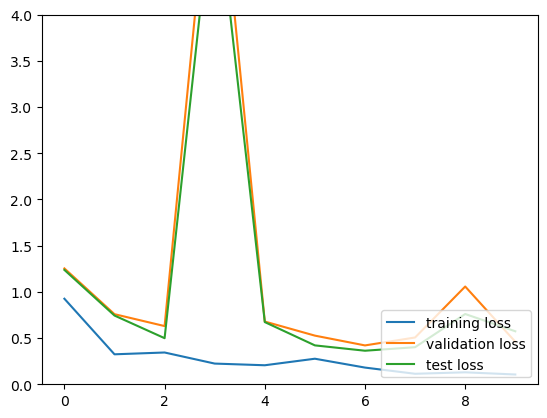

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,4)
plt.show()

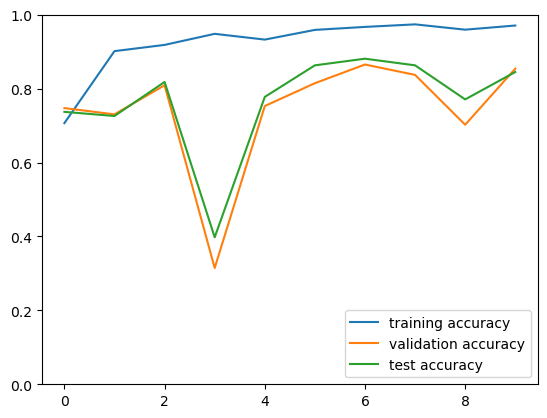

In [31]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()